In [2]:
import sys
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
import numba as nb
import math
import ffmpeg
plt.rcParams['animation.ffmpeg_path'] = '/Users/zach/.virtualenvs/model1/lib/python3.9/site-packages/ffmpeg/'
sys.path.append('../')
from model import Model, feedforward_signal, feedback_signal
from image_generation import generate_block, generate_2_blocks
from scipy import signal, ndimage
from copy import deepcopy
from utils import extract_window, gaussian_1d, gaussian_kernel, runge_kutta2_step

from scipy import signal, ndimage, interpolate
from functools import partial
import cProfile
from pathlib import Path

import matplotlib.animation as animation
import matplotlib as mpl
# from matplotlib import rc
# rc('animation', html='jshtml')
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
cmap='plasma'
np.set_printoptions(precision=3)

import multiprocessing
from simulation import run
import os
import seaborn as sns

In [45]:
PROCESSES = 8



exps = {"40° and 20°": [0, 40, 20],
        "90° and 5°": [0, 90, 5]}  # , "45° and 5°": [135,90,130]}#, "90°": [75, 135]}

simulation = partial(run, orientations=exps["40° and 20°"])

with multiprocessing.Pool(PROCESSES) as pool:
#     params = [(1, ), (2, ), (3, ), (4, )]
    multiple_results = [pool.apply_async(simulation, ()) for _ in range(1000)]

    results = np.array([res.get(timeout=200) for res in multiple_results])
    
    print(results.shape)
    
    cen1s = results[:,0,:]
    cen2s = results[:,1,:]
#     bcks = results[:,2,:]
    
#     print(cen1s.shape)
#     plt.plot(np.sum(cen2s, axis=0))
    

    
    
    
    


(1000, 2, 600)


<IPython.core.display.Javascript object>


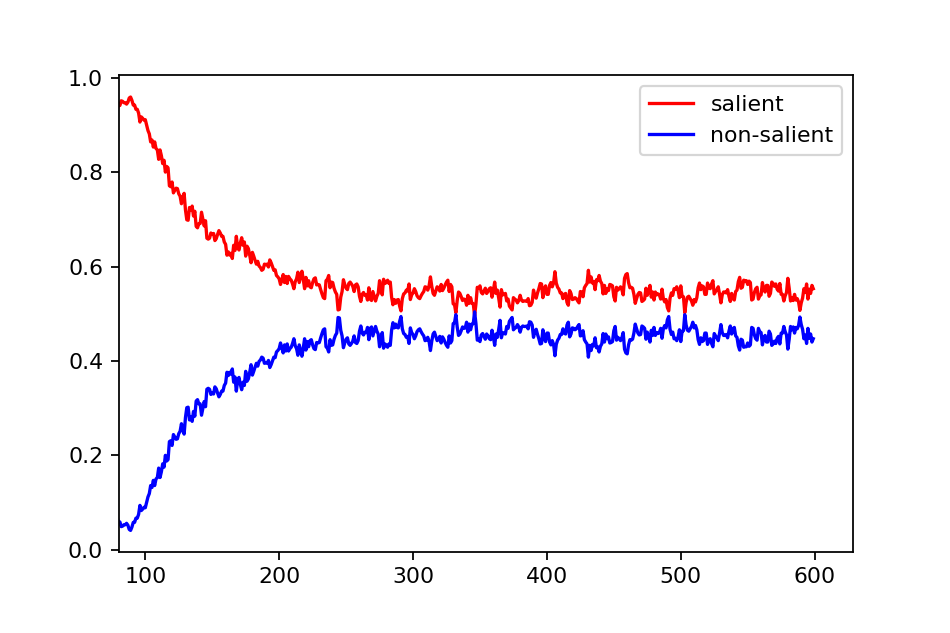

In [46]:
cen1_bigger = (np.ones_like(cen1s) * cen1s > cen2s) / cen1s.shape[0]
cen2_bigger = (np.ones_like(cen2s) * cen2s > cen1s) / cen2s.shape[0]
plt.plot(np.sum(cen1_bigger, axis=0), color='r', label='salient')
plt.plot(np.sum(cen2_bigger, axis=0), color='b', label='non-salient')
# plt.ylim((0,1))
plt.xlim(80)
plt.legend()

In [94]:
cen1_bigger = (np.ones_like(cen1s) * cen1s > cen2s) #/ cen1s.shape[0]
cen2_bigger = (np.ones_like(cen2s) * cen2s > cen1s) #/ cen2s.shape[0]
# plt.plot(np.sum(cen1_bigger, axis=0))
# plt.plot(np.sum(cen2_bigger, axis=0)[40:], color='b', label='non-salient')
# plt.ylim((0.4,1))
# plt.xlim(100)
# plt.legend()

In [91]:
cen1s.shape

(1000, 600)

In [87]:
salient = pd.DataFrame(cen1s, columns=[i for i in range(600)])
salient['subject'] = [i for i in range(1000)]
salient = salient.melt(id_vars='subject', var_name='timepoint', value_name='signal')
salient['figure'] = [1 for _ in range(len(salient.subject.values))]

non_salient = pd.DataFrame(cen2s, columns=[i for i in range(600)])
non_salient['subject'] = [i for i in range(1000)]
non_salient = non_salient.melt(id_vars='subject', var_name='timepoint', value_name='signal')
non_salient['figure'] = [2 for _ in range(len(non_salient.subject.values))]



full = pd.concat([salient, non_salient], ignore_index=True)
# pd.DataFrame({'subject': pd.concat([salient.subject, non_salient.subject]), 
#                      'timepoint': pd.concat([salient.timepoint, non_salient.timepoint]),
#                      'signal': pd.concat([salient.signal1, non_salient.signal2]),
#                      'figure':pd.concat([salient.figure, non_salient.figure])
#                     })





In [95]:
salient = pd.DataFrame(cen1_bigger, columns=[i for i in range(600)])
salient['subject'] = [i for i in range(1000)]
salient = salient.melt(id_vars='subject', var_name='timepoint', value_name='P()')
salient['figure'] = [1 for _ in range(len(salient.subject.values))]

non_salient = pd.DataFrame(cen2_bigger, columns=[i for i in range(600)])
non_salient['subject'] = [i for i in range(1000)]
non_salient = non_salient.melt(id_vars='subject', var_name='timepoint', value_name='signal')
non_salient['figure'] = [2 for _ in range(len(non_salient.subject.values))]



full_prob = pd.concat([salient, non_salient], ignore_index=True)
# pd.DataFrame({'subject': pd.concat([salient.subject, non_salient.subject]), 
#                      'timepoint': pd.concat([salient.timepoint, non_salient.timepoint]),
#                      'signal': pd.concat([salient.signal1, non_salient.signal2]),
#                      'figure':pd.concat([salient.figure, non_salient.figure])
#                     })





In [82]:
full.head()

,subject,timepoint,signal,figure
0,0,0,-0.001221,1
1,1,0,-0.000560,1
2,2,0,-0.000956,1
3,3,0,0.001087,1
4,4,0,0.000102,1


<IPython.core.display.Javascript object>


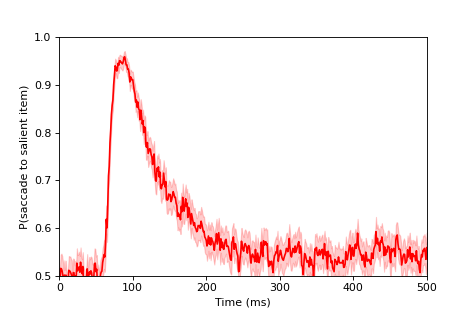

Text(0, 0.5, 'P(saccade to salient item)')

In [148]:
# f, axs = plt.subplots(1,1, figsize=(6,6))
sns.lineplot(x="timepoint", y="signal" , data=salient, color='r')
plt.xlim(0, 500)
plt.ylim(0.5, 1.0)
plt.xlabel("Time (ms)")
plt.ylabel("P(saccade to salient item)")

<IPython.core.display.Javascript object>


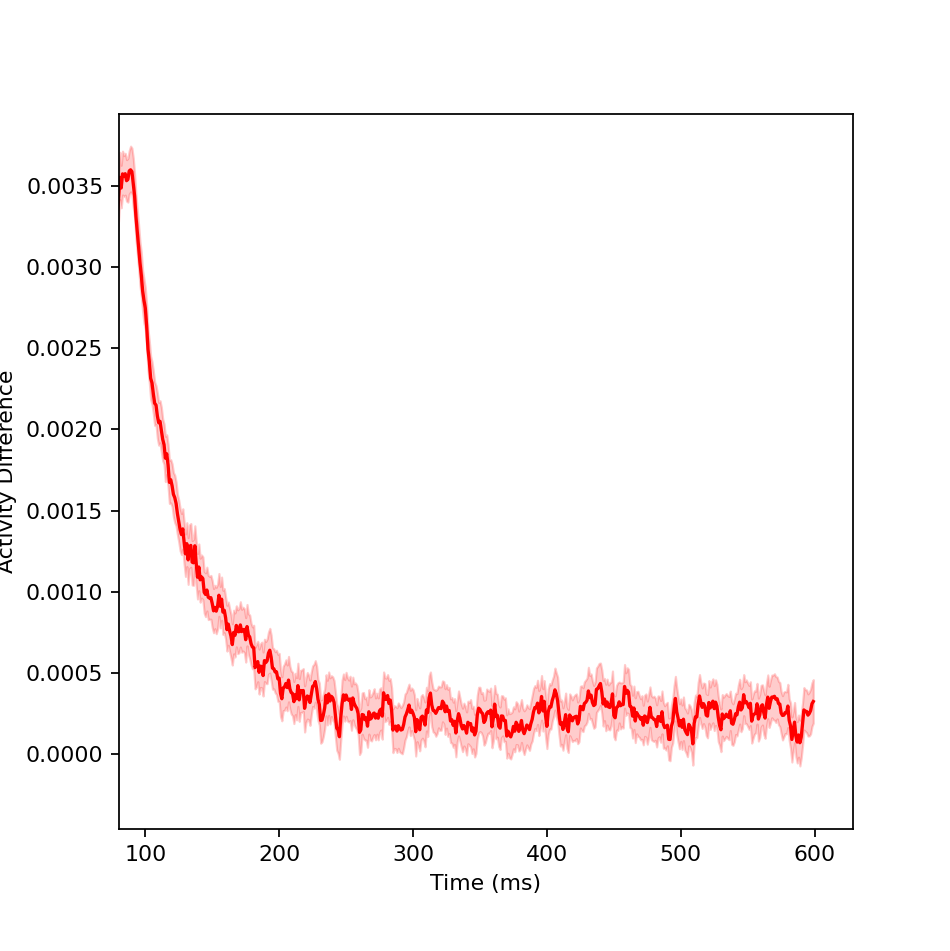

Text(0, 0.5, 'Activity Difference')

In [116]:
f, axs = plt.subplots(1,1, figsize=(6,6))
diff = pd.DataFrame((cen1s-cen2s), columns=[i for i in range(600)])
diff = diff.round(3)
diff['subject'] = [i for i in range(1000)]
diff = diff.melt(id_vars='subject', var_name='timepoint', value_name='signal')
sns.lineplot(x="timepoint", y="signal" ,data=diff, color='r')
plt.xlim(80)
plt.xlabel("Time (ms)")
plt.ylabel("Activity Difference")
# plt.gcf().subplots_adjust(left=0.01)
# sns.lineplot((np.sum(cen1_bigger, axis=(0))- np.sum(cen2_bigger, axis=(0)))[100:])


In [79]:
math.floor(92 * 0.25) 

23

In [76]:

bg = 0
fg1 = 40
fg2 = 20

#     print(f"{it}")
parm_df = pd.read_csv("../parameters.csv", index_col=0)
V1_dim = (183, 183)

na = generate_2_blocks(input_dim=V1_dim, 
                   bg_orientation=bg, 
                   figure_orientations=[fg1, fg2], 
                   figure_dim=(12,12), 
                   midpoints=[(70,70), (111,111)])

model = Model(parm_df, 
              input_dim=V1_dim,
              features=[bg, fg1, fg2], 
              similarity_width=27) 


model.

In [22]:
def run():
    parm_df = pd.read_csv("../parameters.csv", index_col=0)
    orientations = [0,40,20]
    sigma = 27
    exps = {"40° and 20°": [0,40,20], 
        "90° and 5°": [0,90,5]}#, "45° and 5°": [135,90,130]}#, "90°": [75, 135]}
    stimuli ={"vheus_exp_2": {"V4": {"bg": (8,10,10,12), "cen1": (2,4,4,6), "cen2": (15,17,17,19)},
                        "V1": {"bg": (80,96,64,80), "cen1": (15,29,33,45), "cen2": (121,135, 138,150)}},
         "vheus_exp_1": {"FEF": {"bg": (1,3,1,3), "cen1": (8,10,8,10), "cen2": (13,15,13,15)},
                         "V4": {"bg": (1,3,1,3), "cen1": (8,10,8,10), "cen2": (13,15,13,15)},
                         "V2": {"bg": (5,10,5,10), "cen1": (32,38,32,38), "cen2": (53,59,53,59)},
                        "V1": {"bg": (10,20,10,20), "cen1": (64,76,64,76), "cen2": (105,117,105,117)}}}
    results = {k: {"bck": [], "fig1": [], "fig2": [], "V4": [], "V1": [], "fig1_alone": [],
              "fig2_alone": [], "fig1_act_map": [], "fig2_act_map": [],
              "bck_act_map": [], "V2": [], "LGN": [], "FEF": [], "FEFU": []} for k in exps.keys()}

    
    bg = orientations[0]
    fg1 = orientations[1]
    fg2 = orientations[2]

#     print(f"{it}")

    V1_dim = (183, 183)

    na = generate_2_blocks(input_dim=V1_dim, 
                       bg_orientation=bg, 
                       figure_orientations=[fg1, fg2], 
                       figure_dim=(12,12), 
                       midpoints=[(70,70), (111,111)])

    model = Model(parm_df, 
                  input_dim=V1_dim,
                  features=[bg, fg1, fg2], 
                  similarity_width=sigma) 
    n = 600
    empty = np.full_like(na, -1)

    cen1 = []
    cen2 = []
    bck = []
    for i in range(n):
        if i < 40:  
            model.update(empty, 10e-3)
        else: 
            model.update(na, 10e-3)

        FEF = np.mean(np.array([model.FEF[f].V for f in range(len(model.features))]), axis=0 )

        layer = "FEF"
        stim = stimuli["vheus_exp_1"][layer]
        bck_i = stim["bg"]
        cen1_i = stim["cen1"]
        cen2_i = stim["cen2"]

        bck.append(np.mean(FEF[bck_i[0]:bck_i[1],bck_i[2]:bck_i[3]]))
        cen1.append(np.mean(FEF[cen1_i[0]:cen1_i[1],cen1_i[2]:cen1_i[3]]))
        cen2.append(np.mean(FEF[cen2_i[0]:cen2_i[1],cen2_i[2]:cen2_i[3]]))

    
    return cen1, cen2, bck


Background: 0, fg1: 40, fg2: 20
Background: 0, fg1: 90, fg2: 5


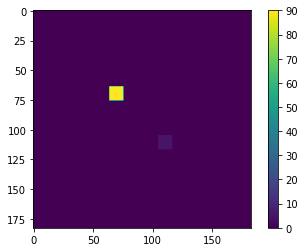

In [20]:
%matplotlib inline
parm_df = pd.read_csv("../parameters.csv", index_col=0)

sigma = 27
exps = {"40° and 20°": [0,40,20], 
        "90° and 5°": [0,90,5]}#, "45° and 5°": [135,90,130]}#, "90°": [75, 135]}
results = {k: {"bck": [], "fig1": [], "fig2": [], "V4": [], "V1": [], "fig1_alone": [],
              "fig2_alone": [], "fig1_act_map": [], "fig2_act_map": [],
              "bck_act_map": [], "V2": [], "LGN": [], "FEF": [], "FEFU": []} for k in exps.keys()}

#     bck = np.mean(res[:,7:8,7:8], axis=(1,2))
#     cen1 = np.mean(res[:,2:5,2:5], axis=(1,2))
#     cen2 =np.mean(res[:,10:13,10:13], axis=(1,2))

stimuli ={"vheus_exp_2": {"V4": {"bg": (8,10,10,12), "cen1": (2,4,4,6), "cen2": (15,17,17,19)},
                        "V1": {"bg": (80,96,64,80), "cen1": (15,29,33,45), "cen2": (121,135, 138,150)}},
         "vheus_exp_1": {"FEF": {"bg": (1,3,1,3), "cen1": (8,10,8,10), "cen2": (13,15,13,15)},
                         "V4": {"bg": (1,3,1,3), "cen1": (8,10,8,10), "cen2": (13,15,13,15)},
                         "V2": {"bg": (5,10,5,10), "cen1": (32,38,32,38), "cen2": (53,59,53,59)},
                        "V1": {"bg": (10,20,10,20), "cen1": (64,76,64,76), "cen2": (105,117,105,117)}}}
for exp, orientations in exps.items():
    bg = orientations[0]
    fg1 = orientations[1]
    fg2 = orientations[2]
    
    print(f"Background: {bg}, fg1: {fg1}, fg2: {fg2}")
    
    V1_dim = (183, 183)

    na = generate_2_blocks(input_dim=V1_dim, 
                       bg_orientation=bg, 
                       figure_orientations=[fg1, fg2], 
                       figure_dim=(12,12), 
                       midpoints=[(70,70), (111,111)])
    
    model = Model(parm_df, 
                  input_dim=V1_dim,
                  features=[bg, fg1, fg2], 
                  similarity_width=sigma) 

#     plt.imshow(((1/1) * (-5 * model.FEF[0].V + -(model.V4[0].V - 5))) + np.sqrt(1/1) * np.random.normal(0.0, 5, model.FEF[0].V.shape))
    n = 600
    empty = np.full_like(na, -1)
    for i in range(n):
        if i < 40:  
            model.update(empty, 10e-3)
        else: 
            model.update(na, 10e-3)

#         results[exp]["bck"].append(np.mean([model.V4[f].V[7,7] for f in range(len(model.features))]))
#         results[exp]["fig1"].append(np.mean([model.V4[f].V[3, 3] for f in range(len(model.features))]))
#         results[exp]["fig2"].append(np.mean([model.V4[f].V[11, 11] for f in range(len(model.features))]))  
        
#         results[exp]["fig1_alone"].append(np.mean(model.V4[1].V[2:5, 2:5]))
#         results[exp]["fig2_alone"].append(np.mean(model.V4[2].V[10:13, 10:13]))
        
#         results[exp]["fig1_act_map"].append(model.V4[1].V)
#         results[exp]["fig2_act_map"].append(model.V4[2].V)
#         results[exp]["bck_act_map"].append(model.V4[0].S)     
        
        results[exp]["V4"].append(np.mean(np.array([model.V4[f].V for f in range(len(model.features))]), axis=0 ))
        results[exp]["V1"].append(np.mean(np.array([model.V1[f].V for f in range(len(model.features))]), axis=0 ))
        results[exp]["LGN"].append(np.mean(np.array([model.LGN[f].V for f in range(len(model.features))]), axis=0 ))
        results[exp]["V2"].append(np.mean(np.array([model.V2[f].V for f in range(len(model.features))]), axis=0 ))
        results[exp]["FEF"].append(np.mean(np.array([model.FEF[f].V for f in range(len(model.features))]), axis=0 ))
#         results[exp]["FEFU"].append(np.mean(np.array([model.FEF[f].U for f in range(len(model.features))]), axis=0 ))
#         print(i)
#     break
        
        

plt.imshow(na)
plt.colorbar()



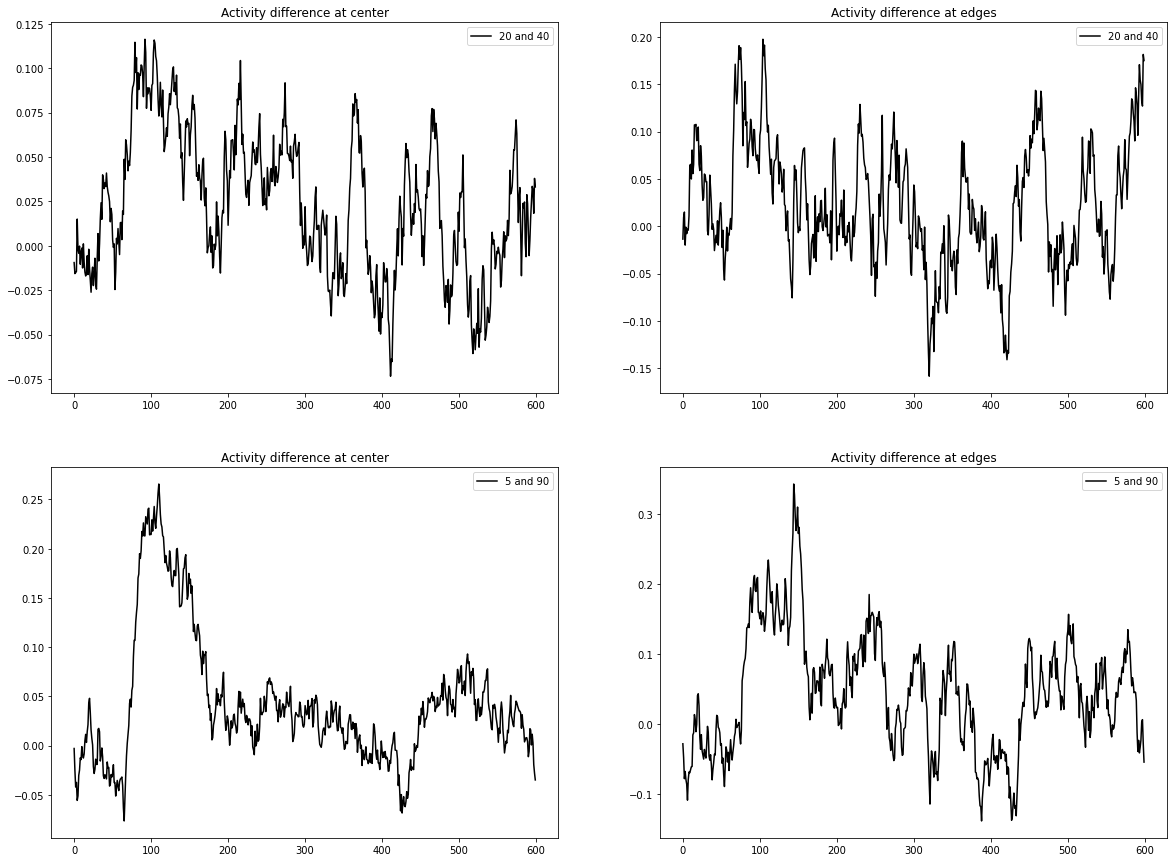

In [21]:
%matplotlib inline

f, axs = plt.subplots(len(exps.keys()),2, figsize=(20,15))


exps_colours = ['b', 'g', 'k', 'y', 'm']

for i in range(len(exps.keys())):
    layer = "FEF"
    stim = stimuli["vheus_exp_1"][layer]
    bck_i = stim["bg"]
    cen1_i = stim["cen1"]
    cen2_i = stim["cen2"]
    exp = list(exps.keys())[i]
    layer = "FEF"
    res = np.array(results[exp][layer])

    bck = np.mean(res[:,bck_i[0]:bck_i[1],bck_i[2]:bck_i[3]], axis=(1,2))
    cen1 = np.mean(res[:,cen1_i[0]:cen1_i[1],cen1_i[2]:cen1_i[3]], axis=(1,2))
    cen2 =np.mean(res[:,cen2_i[0]:cen2_i[1],cen2_i[2]:cen2_i[3]], axis=(1,2))
    edge1 = res[:,cen1_i[0],cen1_i[2]]
    edge2 = res[:,cen2_i[0],cen2_i[2]]
    maxV4 = np.max([bck, cen1, cen2])
    diff1 = cen1 / maxV4 # - bck / maxV4
    diff2 = cen2 / maxV4# - bck / maxV4
    diff3 = diff1 - diff2
    
    ediff1 = edge1 / maxV4# - bck / maxV4
    ediff2 = edge2 / maxV4# - bck / maxV4
    ediff3 = ediff1 - ediff2
    
    lab0 = str(exps[exp][0])
    lab1 = str(exps[exp][1])
    lab2 = str(exps[exp][2])
    
#     axs[i,0].plot(diff1, exps_colours[0], label=lab0+" - "+lab1)
#     axs[i,0].plot(diff2, exps_colours[1], label=lab0+" - "+lab2)
    axs[i,0].plot(diff3, exps_colours[2], label=lab2+" and "+lab1)
    axs[i,0].legend()
    axs[i,0].title.set_text("Activity difference at center")
    
#     axs[i,1].plot(diff1, exps_colours[0], label=lab0+" - "+lab1)
#     axs[i,1].plot(diff2, exps_colours[1], label=lab0+" - "+lab2)
    axs[i,1].plot(ediff3, exps_colours[2], label=lab2+" and "+lab1)
    axs[i,1].legend()
    axs[i,1].title.set_text("Activity difference at edges")
    
#     axs[i,1].plot(np.cumsum(diff1), exps_colours[0], label=lab0+" - "+lab1)
#     axs[i,1].plot(np.cumsum(diff2), exps_colours[1], label=lab0+" - "+lab2)
#     axs[i,1].plot(np.cumsum(diff3), exps_colours[2], label=lab2+" - "+lab1)
#     axs[i,1].legend()
#     axs[i,1].title.set_text("Cumulative activity difference")

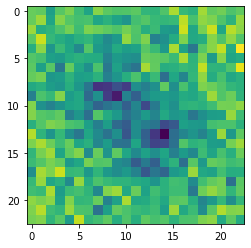

In [8]:
plt.imshow(results['40° and 20°']["FEF"][399])

In [119]:

PROCESSES = 2
with multiprocessing.Pool(PROCESSES) as pool:
    multiple_results = [pool.apply_async(os.getpid, ()) for i in range(4)]
    print([res.get(timeout=1) for res in multiple_results])

[<multiprocessing.pool.ApplyResult object at 0x152a90a60>, <multiprocessing.pool.ApplyResult object at 0x152acbfd0>, <multiprocessing.pool.ApplyResult object at 0x152acb670>, <multiprocessing.pool.ApplyResult object at 0x152971a60>]


In [103]:
import multiprocessing

# def run(accum):
#     orientations = [0,40,20]
    
#     bg = orientations[0]
#     fg1 = orientations[1]
#     fg2 = orientations[2]

# #     print(f"{it}")

#     V1_dim = (183, 183)

#     na = generate_2_blocks(input_dim=V1_dim, 
#                        bg_orientation=bg, 
#                        figure_orientations=[fg1, fg2], 
#                        figure_dim=(12,12), 
#                        midpoints=[(70,70), (111,111)])

#     model = Model(parm_df, 
#                   input_dim=V1_dim,
#                   features=[bg, fg1, fg2], 
#                   similarity_width=sigma) 
#     n = 10
#     empty = np.full_like(na, -1)

#     cen1 = []
#     cen2 = []
#     for i in range(n):
#         if i < 40:  
#             model.update(empty, 10e-3)
#         else: 
#             model.update(na, 10e-3)

#         FEF = np.mean(np.array([model.FEF[f].V for f in range(len(model.features))]), axis=0 )

#         layer = "FEF"
#         stim = stimuli["vheus_exp_1"][layer]
#         bck_i = stim["bg"]
#         cen1_i = stim["cen1"]
#         cen2_i = stim["cen2"]

#         bck = np.mean(res[:,bck_i[0]:bck_i[1],bck_i[2]:bck_i[3]], axis=(1,2))
#         cen1.append(np.mean(FEF[cen1_i[0]:cen1_i[1],cen1_i[2]:cen1_i[3]]))
#         cen2.append(np.mean(FEF[cen2_i[0]:cen2_i[1],cen2_i[2]:cen2_i[3]]))


#     accum['cen1'] = cen1
#     accum['cen2'] = cen2
#     return accum


# parm_df = pd.read_csv("../parameters.csv", index_col=0)

# sigma = 27
# exps = {"40° and 20°": [0,40,20]}#, "45° and 5°": [135,90,130]}#, "90°": [75, 135]}
# # results = {k: {"bck": [], "fig1": [], "fig2": [], "V4": [], "V1": [], "fig1_alone": [],
# #               "fig2_alone": [], "fig1_act_map": [], "fig2_act_map": [],
# #               "bck_act_map": [], "V2": [], "LGN": [], "FEF": []} for k in exps.keys()}

# accum = {"cen1": [], "cen2": []}

# stimuli ={"vheus_exp_2": {"V4": {"bg": (8,10,10,12), "cen1": (2,4,4,6), "cen2": (15,17,17,19)},
#                         "V1": {"bg": (80,96,64,80), "cen1": (15,29,33,45), "cen2": (121,135, 138,150)}},
#          "vheus_exp_1": {"FEF": {"bg": (1,3,1,3), "cen1": (8,10,8,10), "cen2": (13,15,13,15)},
#                          "V4": {"bg": (1,3,1,3), "cen1": (8,10,8,10), "cen2": (13,15,13,15)},
#                          "V2": {"bg": (5,10,5,10), "cen1": (32,38,32,38), "cen2": (53,59,53,59)},
#                         "V1": {"bg": (10,20,10,20), "cen1": (64,76,64,76), "cen2": (105,117,105,117)}}}

# def double(a):
#     return a * 2

def driver_func():
    PROCESSES = 4
    results = []
    with multiprocessing.Pool(PROCESSES) as pool:
        accums = [accum for _ in range(10)]
        results = [pool.apply_async(run, ()) for acc in accums]
#         print(len(results))
        cen1s = []
        cen2s = []
        for r in results:
            cen1s.append(np.array(r.get(timeout=500)['cen1']))
            cen2s.append(np.array(r.get(timeout=500)['cen2']))
        
        print(cen1s.shape)

#         for r in results:
#             print('\t', r.get())


driver_func()

Process SpawnPoolWorker-137:
Process SpawnPoolWorker-136:
Process SpawnPoolWorker-135:
Process SpawnPoolWorker-138:
Traceback (most recent call last):
  File "/Users/zach/.pyenv/versions/3.9.10/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/zach/.pyenv/versions/3.9.10/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/zach/.pyenv/versions/3.9.10/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/zach/.pyenv/versions/3.9.10/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
Traceback (most recent call last):
Traceback (most recent call last):
AttributeError: Can't get attribute 'run' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "/Users/zach/.pyenv/versions/3.9.10/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/

KeyboardInterrupt: 

In [102]:
run({"cen1": [], "cen2": []})

{'cen1': [0.0008129697572914343,
  0.0002741117270771568,
  0.0003430191044609936,
  0.00031048736119654313,
  0.0006535089595645679,
  0.0012572908568627542,
  0.00033748610424089994,
  0.000347694494360095,
  0.0005191009028508722,
  0.0010839601749542925],
 'cen2': [-0.00027044038334496075,
  -3.62489100391561e-05,
  0.00021183250627134837,
  0.0006327253107516232,
  4.939834431139277e-05,
  0.0009731654280279652,
  0.0004516043435204012,
  0.0007480679643931897,
  -0.0004922575613834854,
  -0.00048700436472748327]}

In [56]:
%matplotlib inline
parm_df = pd.read_csv("../parameters.csv", index_col=0)

sigma = 27
exps = {"40° and 20°": [0,40,20]}#, "45° and 5°": [135,90,130]}#, "90°": [75, 135]}
results = {k: {"bck": [], "fig1": [], "fig2": [], "V4": [], "V1": [], "fig1_alone": [],
              "fig2_alone": [], "fig1_act_map": [], "fig2_act_map": [],
              "bck_act_map": [], "V2": [], "LGN": [], "FEF": []} for k in exps.keys()}

accum = {"cen1": [], "cen2": []}

stimuli ={"vheus_exp_2": {"V4": {"bg": (8,10,10,12), "cen1": (2,4,4,6), "cen2": (15,17,17,19)},
                        "V1": {"bg": (80,96,64,80), "cen1": (15,29,33,45), "cen2": (121,135, 138,150)}},
         "vheus_exp_1": {"FEF": {"bg": (1,3,1,3), "cen1": (8,10,8,10), "cen2": (13,15,13,15)},
                         "V4": {"bg": (1,3,1,3), "cen1": (8,10,8,10), "cen2": (13,15,13,15)},
                         "V2": {"bg": (5,10,5,10), "cen1": (32,38,32,38), "cen2": (53,59,53,59)},
                        "V1": {"bg": (10,20,10,20), "cen1": (64,76,64,76), "cen2": (105,117,105,117)}}}
for exp, orientations in exps.items():
    for it in range(30):
        bg = orientations[0]
        fg1 = orientations[1]
        fg2 = orientations[2]

        print(f"{it}")

        V1_dim = (183, 183)

        na = generate_2_blocks(input_dim=V1_dim, 
                           bg_orientation=bg, 
                           figure_orientations=[fg1, fg2], 
                           figure_dim=(12,12), 
                           midpoints=[(70,70), (111,111)])

        model = Model(parm_df, 
                      input_dim=V1_dim,
                      features=[bg, fg1, fg2], 
                      similarity_width=sigma) 
        n = 600
        empty = np.full_like(na, -1)
        
        cen1 = []
        cen2 = []
        for i in range(n):
            if i < 40:  
                model.update(empty, 10e-3)
            else: 
                model.update(na, 10e-3)

            FEF = np.mean(np.array([model.FEF[f].V for f in range(len(model.features))]), axis=0 )

            layer = "FEF"
            stim = stimuli["vheus_exp_1"][layer]
            bck_i = stim["bg"]
            cen1_i = stim["cen1"]
            cen2_i = stim["cen2"]

            bck = np.mean(res[:,bck_i[0]:bck_i[1],bck_i[2]:bck_i[3]], axis=(1,2))
            cen1.append(np.mean(FEF[cen1_i[0]:cen1_i[1],cen1_i[2]:cen1_i[3]]))
            cen2.append(np.mean(FEF[cen2_i[0]:cen2_i[1],cen2_i[2]:cen2_i[3]]))

        
        accum['cen1'].append(cen1)
        accum['cen2'].append(cen2)

plt.imshow(na)
plt.colorbar()




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


KeyboardInterrupt: 

In [ ]:
%matplotlib notebook

cen1s = np.array(accum['cen1'])
cen2s = np.array(accum['cen2'])

cen1_bigger = (np.ones_like(cen1s) * cen1s > cen2s) / cen1s.shape[0]
cen2_bigger = (np.ones_like(cen2s) * cen2s > cen1s) / cen2s.shape[0]
plt.plot(np.sum(cen1_bigger, axis=0)[100:], color='r', label='salient')
plt.plot(np.sum(cen2_bigger, axis=0)[100:], color='b', label='non-salient')
plt.ylim((0,1))
plt.xlim(100)
plt.legend()

In [ ]:
# plt.plot((np.mean(cen1s, axis=(0))- np.mean(cen2s, axis=(0)))[100:])
plt.plot((np.sum(cen1_bigger, axis=0)[100:] - np.sum(cen2_bigger, axis=0)[100:]))
# plt.plot()

In [85]:
240*0.25

60.0

<IPython.core.display.Javascript object>


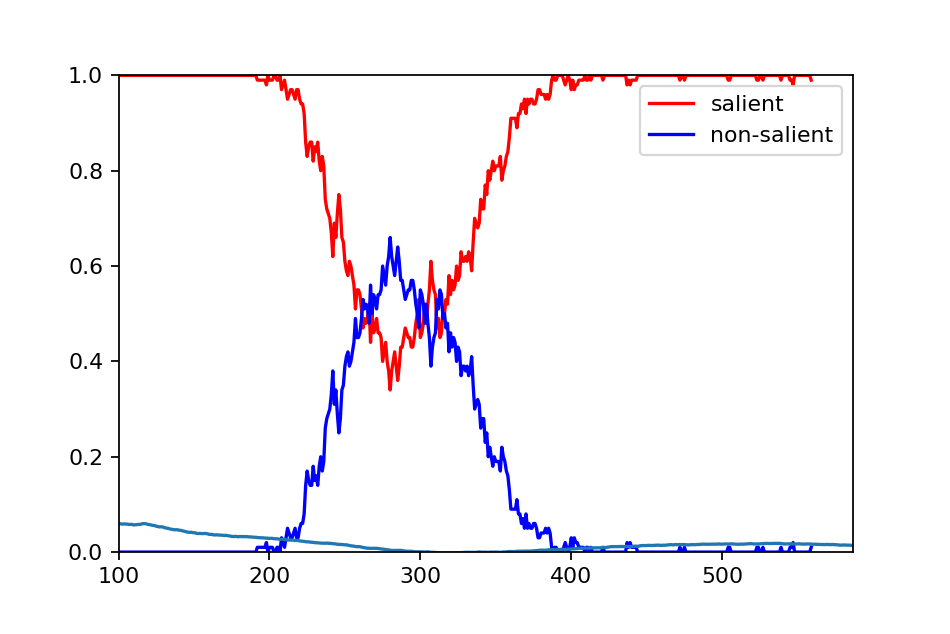

In [79]:
%matplotlib notebook

cen1s = np.array(accum['cen1'])
cen2s = np.array(accum['cen2'])

cen1_bigger = np.ones_like(cen1s) * cen1s > cen2s 
cen2_bigger = np.ones_like(cen2s) * cen2s > cen1s
plt.plot(np.sum(cen1_bigger, axis=0)[40:] / 100, color='r', label='salient')
plt.plot(np.sum(cen2_bigger, axis=0)[40:] / 100, color='b', label='non-salient')
plt.ylim((0,1))
plt.xlim(100)
plt.legend()

<IPython.core.display.Javascript object>


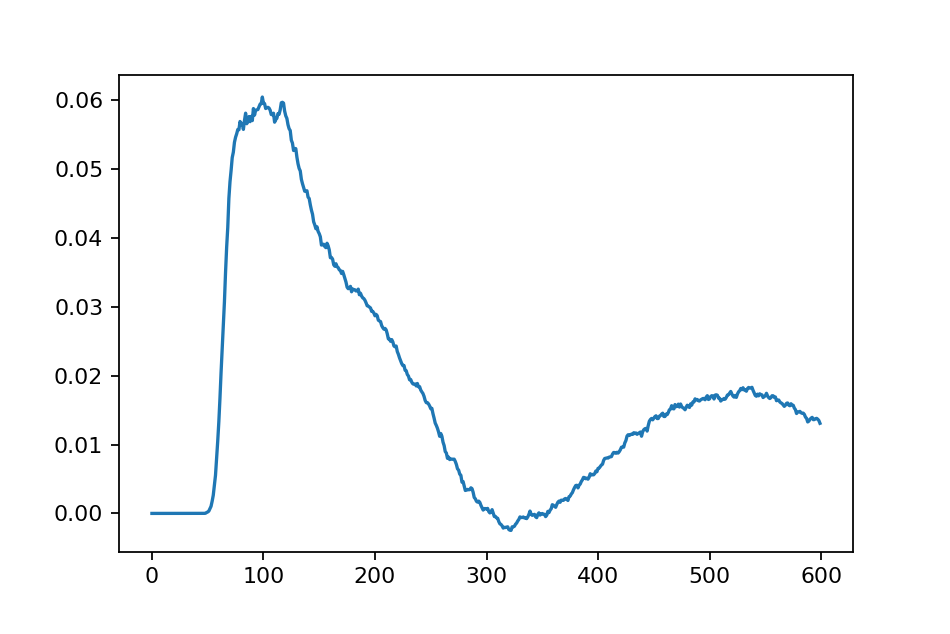

In [81]:
plt.plot(np.mean(cen1s, axis=(0))- np.mean(cen2s, axis=(0)))
# plt.plot()

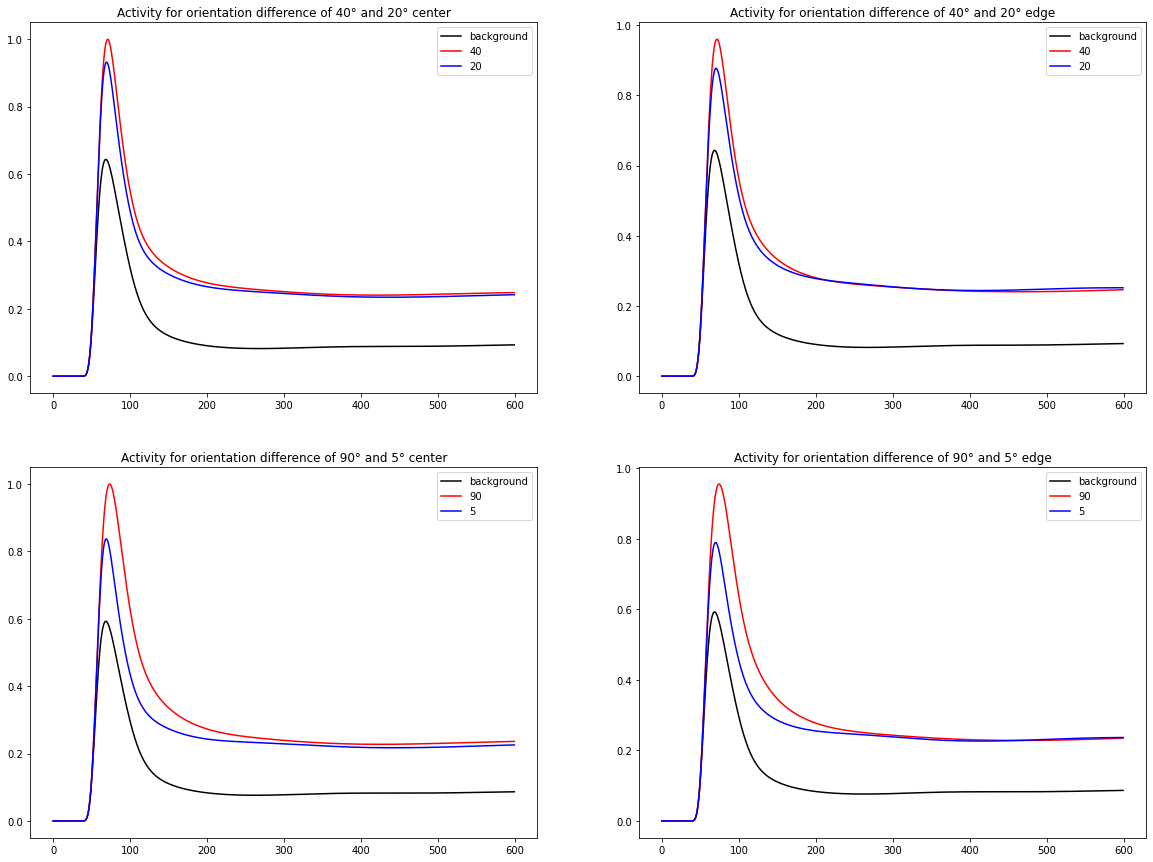

In [5]:
%matplotlib inline

# print(np.mean(res[:,2:3,2:3], axis=(1,2)).shape)
f, axs = plt.subplots(2, len(exps.keys()), figsize=(20,15))

for i in range(len(exps.keys())):
    layer = "V4"
    stim = stimuli["vheus_exp_1"][layer]
    bck_i = stim["bg"]
    cen1_i = stim["cen1"]
    cen2_i = stim["cen2"]
    exp = list(exps.keys())[i]
    res = np.array(results[exp][layer])

    bck = np.mean(res[:,bck_i[0]:bck_i[1],bck_i[2]:bck_i[3]], axis=(1,2))
    cen1 = np.mean(res[:,cen1_i[0]:cen1_i[1],cen1_i[2]:cen1_i[3]], axis=(1,2))
    cen2 = np.mean(res[:,cen2_i[0]:cen2_i[1],cen2_i[2]:cen2_i[3]], axis=(1,2))
    ej1 = res[:,cen1_i[0],cen1_i[2]]
    ej2 = res[:,cen2_i[0],cen2_i[2]]
    maxV4 = np.max([bck, cen1, cen2])
    axs[i,0].plot(bck / maxV4, 'k', label="background")
    axs[i,0].plot(cen1 / maxV4, 'r', label=np.abs(exps[exp][0]-exps[exp][1]))
    axs[i,0].plot(cen2 / maxV4, 'b', label=np.abs(exps[exp][0]-exps[exp][2]))
    axs[i,0].title.set_text(f"Activity for orientation difference of {exp} center")
    axs[i,0].legend()
    
    axs[i,1].plot(bck / maxV4, 'k', label="background")
    axs[i,1].plot(ej1 / maxV4, 'r', label=np.abs(exps[exp][0]-exps[exp][1]))
    axs[i,1].plot(ej2 / maxV4, 'b', label=np.abs(exps[exp][0]-exps[exp][2]))
    axs[i,1].title.set_text(f"Activity for orientation difference of {exp} edge")
    axs[i,1].legend()


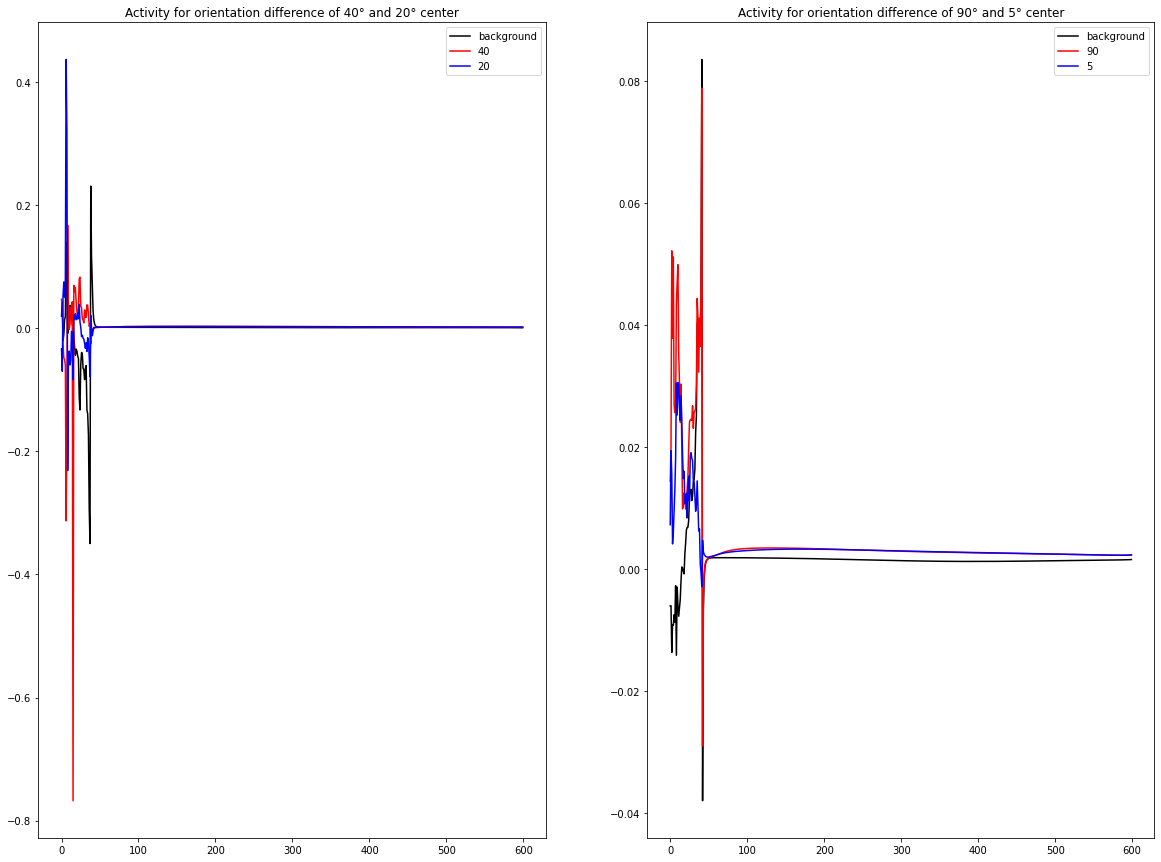

In [31]:
%matplotlib inline

# print(np.mean(res[:,2:3,2:3], axis=(1,2)).shape)
f, axs = plt.subplots(1, len(exps.keys()), figsize=(20,15))

for i in range(len(exps.keys())):
    layer = "FEF"
    stim = stimuli["vheus_exp_1"][layer]
    bck_i = stim["bg"]
    cen1_i = stim["cen1"]
    cen2_i = stim["cen2"]
    exp = list(exps.keys())[i]
    res = np.array(results[exp][layer])
    norm = np.sum(res, axis=(1,2))
    norm[norm==0] = 1
#     norm_act = res / np.sum(res, axis=0)
#     print(norm.shape)
    
    

    bck = np.mean(res[:,bck_i[0]:bck_i[1],bck_i[2]:bck_i[3]], axis=(1,2))
    cen1 = np.mean(res[:,cen1_i[0]:cen1_i[1],cen1_i[2]:cen1_i[3]], axis=(1,2))
    cen2 = np.mean(res[:,cen2_i[0]:cen2_i[1],cen2_i[2]:cen2_i[3]], axis=(1,2))
    ej1 = res[:,cen1_i[0],cen1_i[2]]
    ej2 = res[:,cen2_i[0],cen2_i[2]]
#     maxV4 = np.max([bck, cen1, cen2])
    axs[i].plot(bck / norm, 'k', label="background")
    axs[i].plot(cen1 / norm , 'r', label=np.abs(exps[exp][0]-exps[exp][1]))
    axs[i].plot(cen2 / norm, 'b', label=np.abs(exps[exp][0]-exps[exp][2]))
    axs[i].title.set_text(f"Activity for orientation difference of {exp} center")
    axs[i].legend()
    
#     axs[i,1].plot(bck / maxV4, 'k', label="background")
#     axs[i,1].plot(ej1 / maxV4, 'r', label=np.abs(exps[exp][0]-exps[exp][1]))
#     axs[i,1].plot(ej2 / maxV4, 'b', label=np.abs(exps[exp][0]-exps[exp][2]))
#     axs[i,1].title.set_text(f"Activity for orientation difference of {exp} edge")
#     axs[i,1].legend()


In [298]:
for i in range(len(exps.keys())):
    layer = "V4"
    stim = stimuli["vheus_exp_1"][layer]
    bck_i = stim["bg"]
    cen1_i = stim["cen1"]
    cen2_i = stim["cen2"]
    exp = list(exps.keys())[i]
    res = np.array(results[exp][layer])

    bck = np.mean(res[:,bck_i[0]:bck_i[1],bck_i[2]:bck_i[3]], axis=(1,2))
    cen1 = np.mean(res[:,cen1_i[0]:cen1_i[1],cen1_i[2]:cen1_i[3]], axis=(1,2))
    cen2 = np.mean(res[:,cen2_i[0]:cen2_i[1],cen2_i[2]:cen2_i[3]], axis=(1,2))
    ej1 = res[:,cen1_i[0],cen1_i[2]]
    ej2 = res[:,cen2_i[0],cen2_i[2]]
    maxV4 = np.max([bck, cen1, cen2])

    df = pd.DataFrame({'V4_bck': bck, 'V4_fig1': cen1, 'V4_fig2': cen2})
    df.to_csv(f"{exp}.csv")

In [254]:
parm_df.loc['e1']['V4']

5.0

<IPython.core.display.Javascript object>


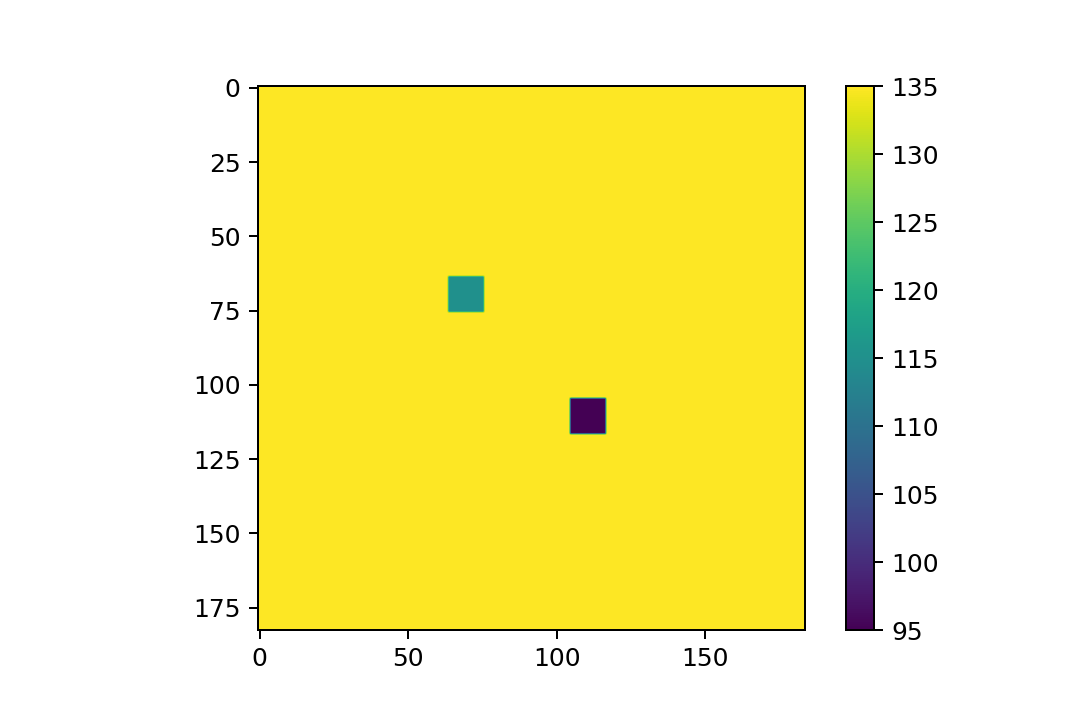

(183, 184)


In [87]:
%matplotlib notebook
# exp 1
na = generate_2_blocks(input_dim=(184, 183), 
                       bg_orientation=135, 
                       figure_orientations=[95, 115], 
                       figure_dim=(12,12), 
                       midpoints=[(111,111),(70,70)])

#exp 2
# V1_na = generate_2_blocks(input_dim=V1_dim, 
#                        bg_orientation=135, 
#                        figure_orientations=[95, 115], 
#                        figure_dim=(12,14), 
#                        midpoints=[(39,22),(144,128)])
# na[150//2, 184//2] = 10
plt.imshow(na)
plt.colorbar()
print(na.shape)

In [61]:
V1_dim = (184, 152)
V2_dim = tuple(math.ceil(V1_dim_i * 0.5) for V1_dim_i in V1_dim)
V4_dim = tuple(math.floor(V2_dim_i * 0.25) for V2_dim_i in V2_dim)

V1_dim, V2_dim, V4_dim

# V4_X, V4_Y = np.linspace(-1, 1, V4_dim[1]), np.linspace(-1, 1, V4_dim[0])
# V4_Y.shape

((184, 152), (92, 76), (23, 19))

(23,)


<IPython.core.display.Javascript object>


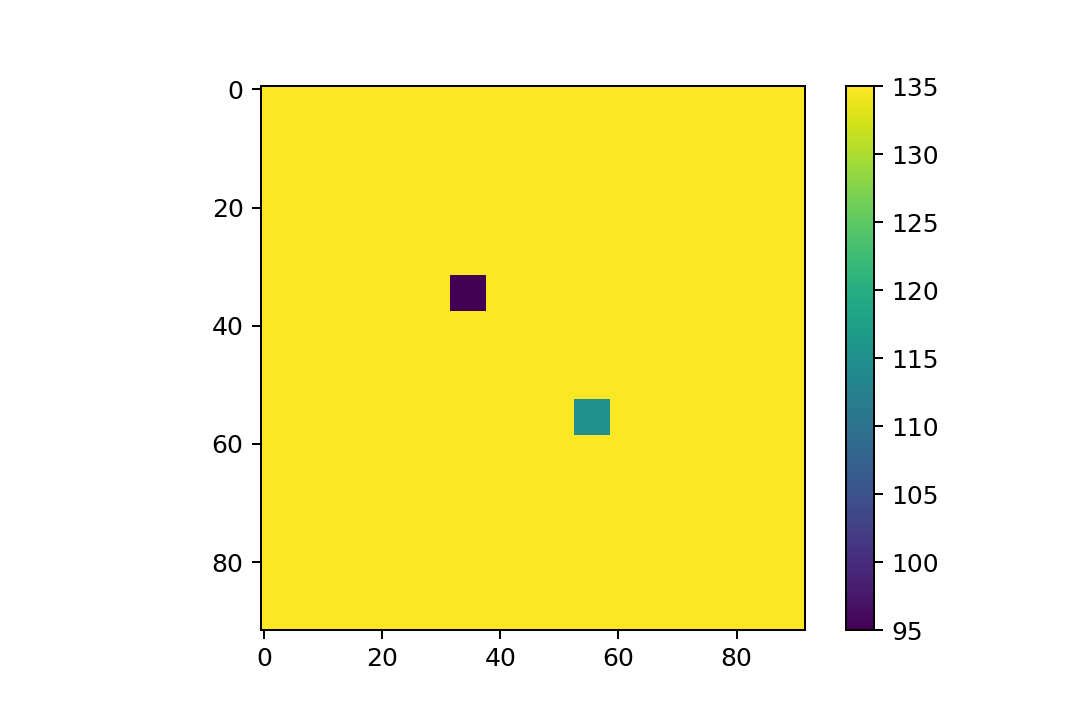

In [187]:
# fig, axs = plt.subplots(1,2, figsize=(20,10))
%matplotlib notebook

V1_dim = (183, 183)

V1_na = generate_2_blocks(input_dim=V1_dim, 
                       bg_orientation=135, 
                       figure_orientations=[95, 115], 
                       figure_dim=(12,12), 
                       midpoints=[(70,70),(111,111)])
model = Model(parm_df, 
                  input_dim=V1_dim,
                  features=[95, 115], 
                  similarity_width=sigma)#, 
# axs[0].imshow(na)
f = interpolate.interp2d(model.V1_X, model.V1_Y, V1_na)
V2_na = f(model.V2_X, model.V2_Y)
# axs[1].imshow(V2_na)

# print(na.shape, V2_na.shape)
# plt.imshow(V2_na)
# plt.colorbar()

g = interpolate.interp2d(model.V2_X, model.V2_Y, V2_na)
V4_na = g(model.V4_X, model.V4_Y)
print(model.V4_X.shape)
# plt.imshow(V1_na[10:20, 10:20])
plt.imshow(V2_na)#[53:59, 53:59])
# plt.imshow(V4_na[13:14, 13:15])
# V4_na[13, 13]
plt.colorbar()

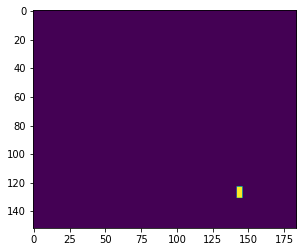

In [9]:
plt.imshow(np.ones_like(na) * (na == 130))

In [17]:
1/30

0.03333333333333333

<IPython.core.display.Javascript object>


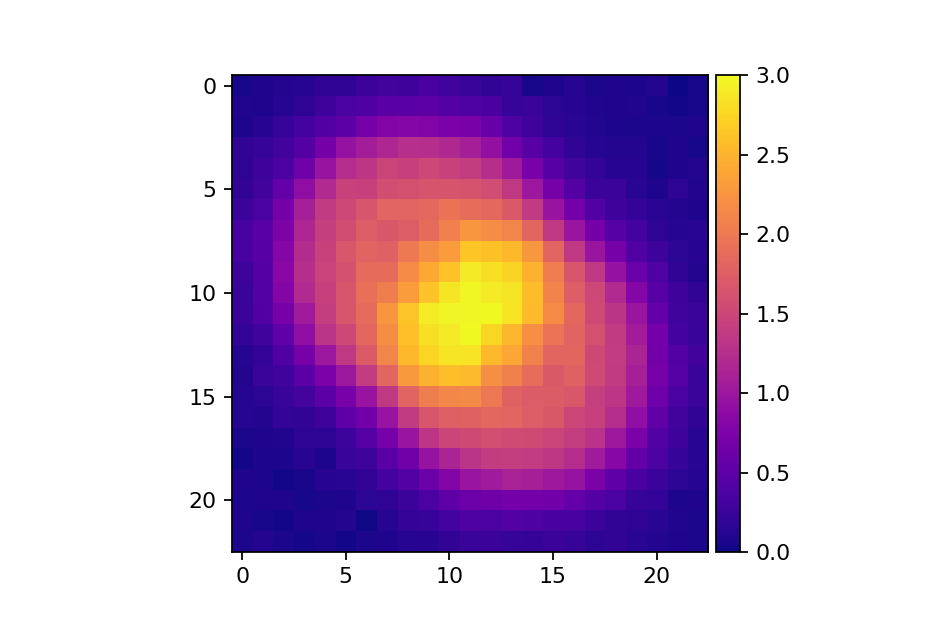

In [4]:
%matplotlib notebook
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame

activity = np.array(results["40° and 20°"]["FEF"])
fig, ax = plt.subplots()
ims = []
for i in range(activity.shape[0]):
    im = ax.imshow(activity[i], cmap=cmap, animated=True)
    if i == 0:
        ax.imshow(activity[i], cmap=cmap)  # show an initial one first
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=30, blit=True,
                                repeat_delay=1000)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# ani.save("background2.gif")
norm = mpl.colors.Normalize(vmin=0, vmax=3)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
# plt.colorbar(ims[300][0], cax=cax)
ani

In [284]:
%matplotlib notebook
res = np.array(results["40° and 20°"]["V4"])
# res.shape
act = np.sum(res, axis=(1,2))
act
# 
# plt.imshow(act[80])
# print(np.mean(res[80,1:3,1:3]))
# plt.colorbar()

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.6396e-01, 8.1424e-01, 2.4195e+00, 5.5729e+00, 1.0957e+01,
       1.9296e+01, 3.1289e+01, 4.7538e+01, 6.8473e+01, 9.4280e+01,
       1.2485e+02, 1.5978e+02, 1.9835e+02, 2.3963e+02, 2.8251e+02,
       3.2584e+02, 3.6846e+02, 4.0936e+02, 4.4768e+02, 4.8274e+02,
       5.1410e+02, 5.4147e+02, 5.6477e+02, 5.8404e+02, 5.9944e+02,
       6.1118e+02, 6.1955e+02, 6.2485e+02, 6.2742e+02, 6.2756e+02,
       6.2557e+02, 6.2175e+02, 6.1637e+02, 6.0965e+02, 6.0182e

In [140]:
for i in range(6):
    print(i // 3, i % 3)

0 0
0 1
0 2
1 0
1 1
1 2


<IPython.core.display.Javascript object>


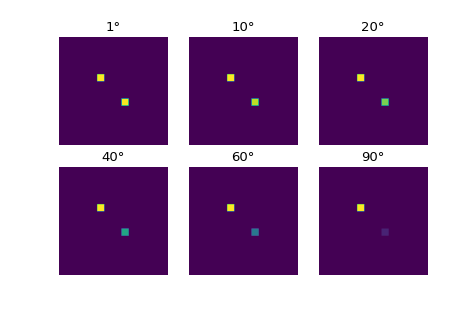

In [146]:
%matplotlib notebook

exps = {
        "1°": [0, 100, 99], 
        "10°": [0,100,90], 
        "20°": [0,100,80], 
        "40°": [0,100,60], 
        "60°": [0, 100, 40],
#         "50°": [0, 100, 50],
#         "70°": [0, 100, 30],
#         "80°": [0, 100, 20],
        "90°": [0, 100, 10], 
       }

f, axs = plt.subplots(2,3)

for i in range(6):
    exp = list(exps.keys())[i]
    bg = exps[exp][0]
    fg1 = exps[exp][1]
    fg2 = exps[exp][2]
    na = generate_2_blocks(input_dim=V1_dim, 
                   bg_orientation=bg, 
                   figure_orientations=[fg1, fg2], 
                   figure_dim=(12,12), 
                   midpoints=[(70,70), (111,111)])
    r = i // 3
    c = i % 3
    axs[r,c].imshow(na)
    axs[r,c].axis('off')
    axs[r,c].set_title(f"{exp}")
    

In [147]:
21*6 + 31*6

312

In [34]:
%matplotlib inline
parm_df = pd.read_csv("../parameters.csv", index_col=0)

exps = {
        "1°": [0, 100, 99], 
        "10°": [0,100,90], 
        "20°": [0,100,80], 
        "40°": [0,100,60], 
        "60°": [0, 100, 40],
#         "50°": [0, 100, 50],
#         "70°": [0, 100, 30],
#         "80°": [0, 100, 20],
        "90°": [0, 100, 10], 
       }
results = {k: {"bck": [], "fig1": [], "fig2": [], "V4": [], "V1": [], "fig1_alone": [],
              "fig2_alone": [], "fig1_act_map": [], "fig2_act_map": [],
              "bck_act_map": [], "V2": [], "LGN": [], "FEF": []} for k in exps.keys()}


stimuli ={"vheus_exp_2": {"V4": {"bg": (8,10,10,12), "cen1": (2,4,4,6), "cen2": (15,17,17,19)},
                        "V1": {"bg": (80,96,64,80), "cen1": (15,29,33,45), "cen2": (121,135, 138,150)}},
         "vheus_exp_1": {"FEF": {"bg": (1,3,1,3), "cen1": (8,10,8,10), "cen2": (13,15,13,15)},
                         "V4": {"bg": (1,3,1,3), "cen1": (8,10,8,10), "cen2": (13,15,13,15)},
                         "V2": {"bg": (5,10,5,10), "cen1": (32,38,32,38), "cen2": (53,59,53,59)},
                        "V1": {"bg": (10,20,10,20), "cen1": (64,76,64,76), "cen2": (105,117,105,117)}}}


for exp, orientations in exps.items():
    bg = orientations[0]
    fg1 = orientations[1]
    fg2 = orientations[2]


    V1_dim = (183, 183)

    na = generate_2_blocks(input_dim=V1_dim, 
                       bg_orientation=bg, 
                       figure_orientations=[fg1, fg2], 
                       figure_dim=(12,12), 
                       midpoints=[(70,70), (111,111)])

    model = Model(parm_df, 
                  input_dim=V1_dim,
                  features=[bg, fg1, fg2]) 
    n = 600
    empty = np.full_like(na, -1)

    cen1 = []
    cen2 = []
    for i in range(n):
        if i < 40:  
            model.update(empty, 10e-3)
        else: 
            model.update(na, 10e-3)
            
        results[exp]["V1"].append(np.mean(np.array([model.V1[f].V for f in range(len(model.features))]), axis=0))
        results[exp]["V2"].append(np.mean(np.array([model.V2[f].V for f in range(len(model.features))]), axis=0))
        results[exp]["V4"].append(np.mean(np.array([model.V4[f].V for f in range(len(model.features))]), axis=0))





<IPython.core.display.Javascript object>


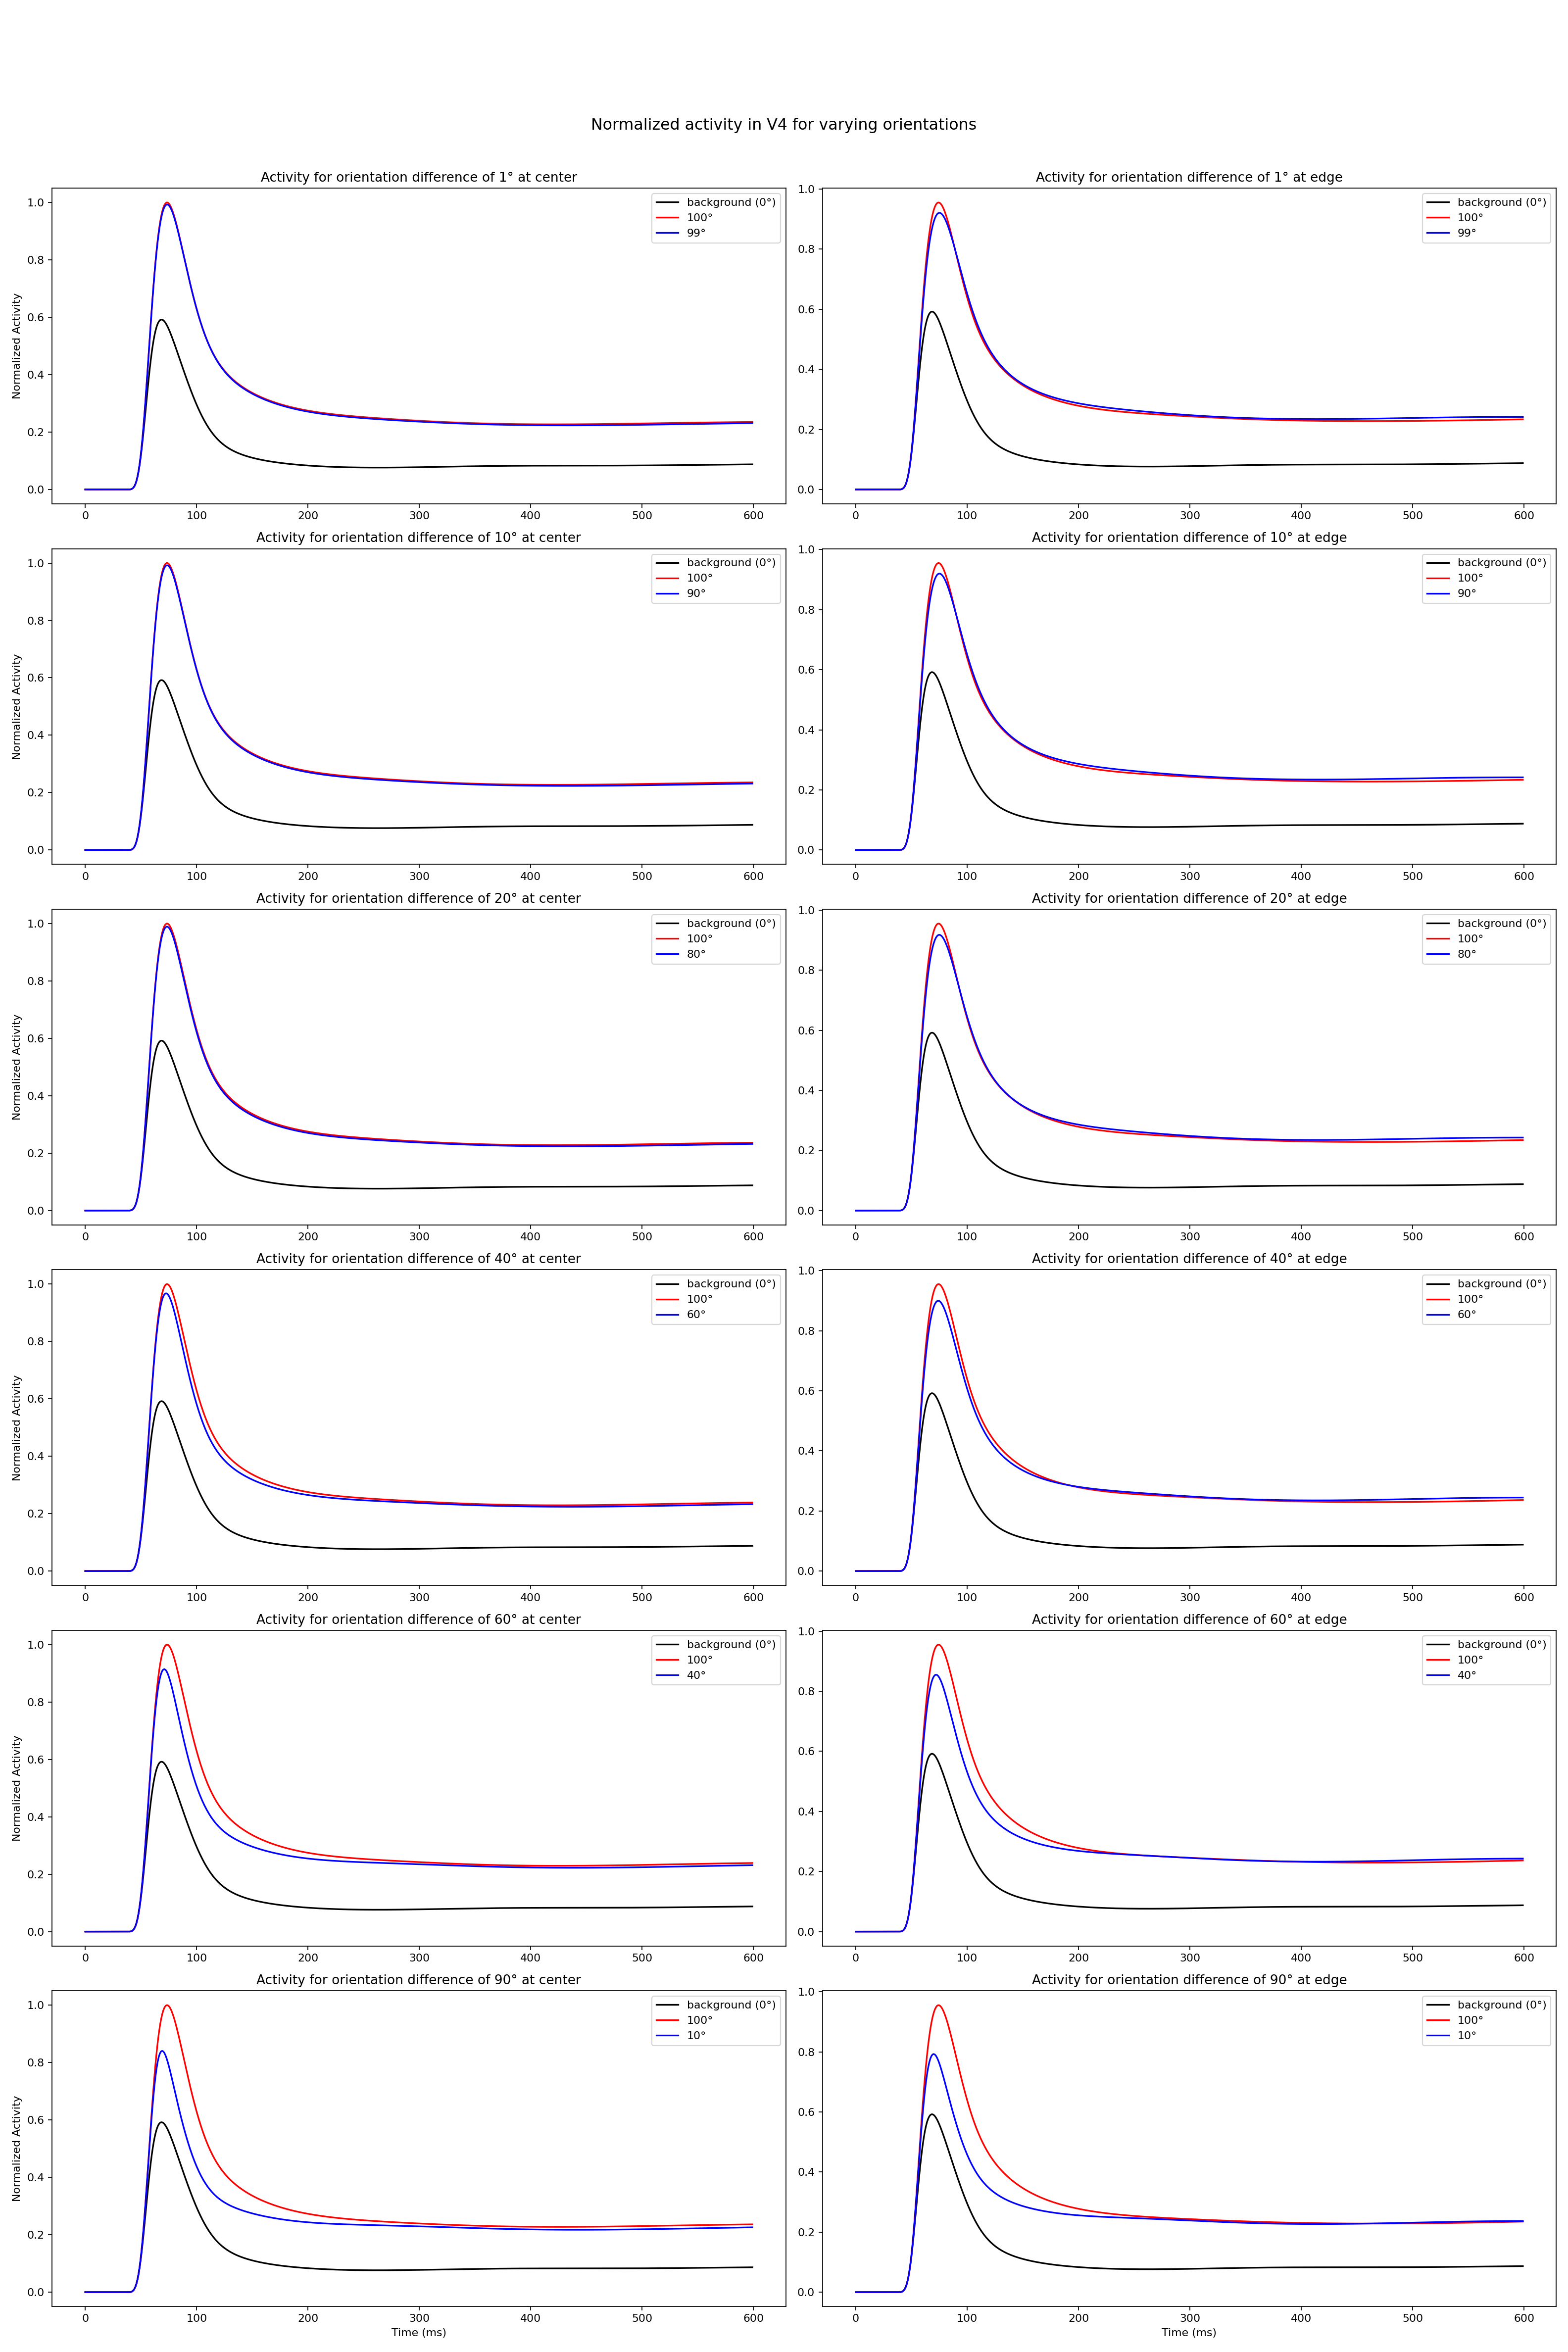

In [42]:
%matplotlib notebook

exp_keys = list(exps.keys())
# exp_keys.sort()

# print(np.mean(res[:,2:3,2:3], axis=(1,2)).shape)
f, axs = plt.subplots(len(exp_keys), 2, figsize=(20,30))

for i in range(len(exp_keys)):
    layer = "V4"
    stim = stimuli["vheus_exp_1"][layer]
    bck_i = stim["bg"]
    cen1_i = stim["cen1"]
    cen2_i = stim["cen2"]
    exp = exp_keys[i]
    res = np.array(results[exp][layer])

    bck = np.mean(res[:,bck_i[0]:bck_i[1],bck_i[2]:bck_i[3]], axis=(1,2))
    cen1 = np.mean(res[:,cen1_i[0]:cen1_i[1],cen1_i[2]:cen1_i[3]], axis=(1,2))
    cen2 = np.mean(res[:,cen2_i[0]:cen2_i[1],cen2_i[2]:cen2_i[3]], axis=(1,2))
    ej1 = res[:,cen1_i[0],cen1_i[2]]
    ej2 = res[:,cen2_i[0],cen2_i[2]]
    maxV4 = np.max([bck, cen1, cen2])
    axs[i,0].plot(bck / maxV4, 'k', label="background (0°)")
    axs[i,0].plot(cen1 / maxV4, 'r', label=f"{np.abs(exps[exp][0]-exps[exp][1])}°")
    axs[i,0].plot(cen2 / maxV4, 'b', label=f"{np.abs(exps[exp][0]-exps[exp][2])}°")
    axs[i,0].title.set_text(f"Activity for orientation difference of {exp} at center")
    axs[i,0].set_ylabel("Normalized Activity")
    axs[i,0].legend()
    
    axs[i,1].plot(bck / maxV4, 'k', label="background (0°)")
    axs[i,1].plot(ej1 / maxV4, 'r', label=f"{np.abs(exps[exp][0]-exps[exp][1])}°")
    axs[i,1].plot(ej2 / maxV4, 'b', label=f"{np.abs(exps[exp][0]-exps[exp][2])}°")
    axs[i,1].title.set_text(f"Activity for orientation difference of {exp} at edge")
    axs[i,1].legend()

axs[len(exps.keys())-1, 0].set_xlabel("Time (ms)")
axs[len(exps.keys())-1, 1].set_xlabel("Time (ms)")

st = f.suptitle(f"Normalized activity in {layer} for varying orientations", fontsize="x-large")
f.tight_layout()
st.set_y(0.95)
f.subplots_adjust(top=0.92)

<IPython.core.display.Javascript object>


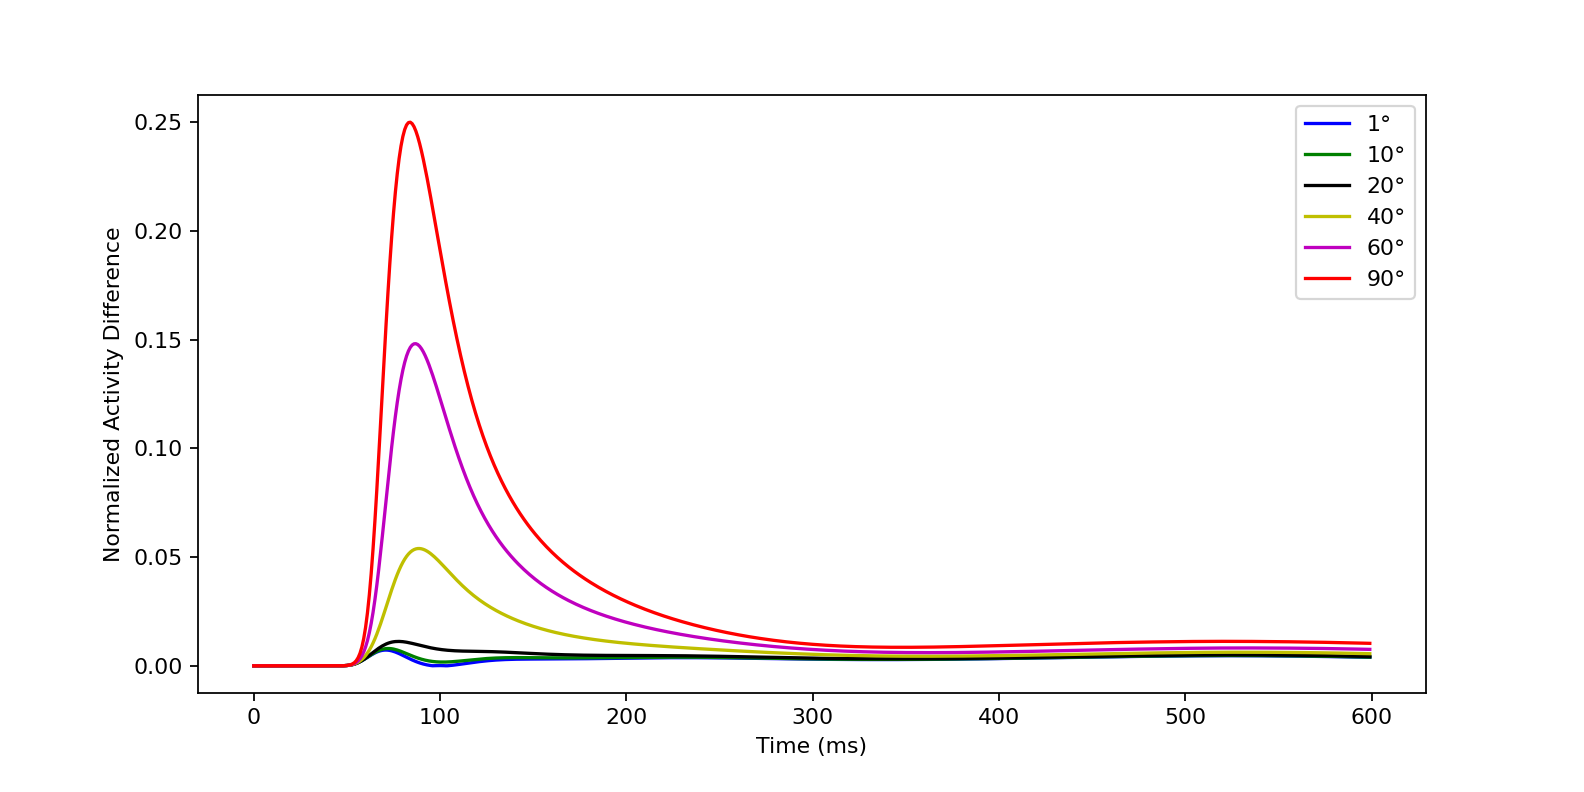

In [44]:
%matplotlib notebook 
f, axs = plt.subplots(1,1, figsize=(10,5))

exps_colours = ['b', 'g', 'k', 'y', 'm', 'r']

for i in range(len(exp_keys)):
    layer = "V4"
    stim = stimuli["vheus_exp_1"][layer]
    bck_i = stim["bg"]
    cen1_i = stim["cen1"]
    cen2_i = stim["cen2"]
    
    exp = exp_keys[i]
    res = np.array(results[exp][layer])

    
    
    bck = np.mean(res[:,bck_i[0]:bck_i[1],bck_i[2]:bck_i[3]], axis=(1,2))
    cen1 = np.mean(res[:,cen1_i[0]:cen1_i[1],cen1_i[2]:cen1_i[3]], axis=(1,2))
    cen2 = np.mean(res[:,cen2_i[0]:cen2_i[1],cen2_i[2]:cen2_i[3]], axis=(1,2))
    ej1 = res[:,cen1_i[0],cen1_i[2]]
    ej2 = res[:,cen2_i[0],cen2_i[2]]
    maxV4 = np.max([bck, cen1, cen2])
    
    diff1 = cen1 / maxV4 - bck / maxV4
    diff2 = cen2 / maxV4 - bck / maxV4
    diff3 = np.abs(cen1 / maxV4 - cen2 / maxV4)
    
    lab0 = str(exps[exp][0])
    lab1 = str(exps[exp][1])
    lab2 = str(exps[exp][2])
    
    axs.plot(diff3, exps_colours[i], label=exp)
    axs.legend()
#     axs.title.set_text(f"Activity difference between figures for varying orientation in {layer}")
    axs.set_xlabel("Time (ms)")
    axs.set_ylabel("Normalized Activity Difference")





    